## Setup

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset

from src.data import DataLoaderScratch
from src.trainer import TrainerScratch
from src.optimizers import SGDScratch

## Load Data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
mnist_trainset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

## Preprocessing

In [3]:
# Transform the training data
X_train = mnist_trainset.data.float() / 255.0
X_train = X_train.view(X_train.shape[0], -1)
y_train = mnist_trainset.targets

# Transform the test data
X_val = mnist_testset.data.float() / 255.0
X_val = X_val.view(X_val.shape[0], -1)
y_val = mnist_testset.targets

train_dataloader = DataLoaderScratch(X_train, y_train, batch_size=256, shuffle=True)
val_dataloader = DataLoaderScratch(X_val, y_val, batch_size=256, shuffle=False)

## Logistic Regression From Scratch

### Single Batch from Scratch

In [4]:
num_samples = X_train.shape[0]
num_classes = y_train.unique().shape[0]
batch_size = 64

# Initialize W, it should be shape (num_features, num_classes) because it will 
# transform the input (num_examples, num_features) to the output (num_examples, num_classes)
W = torch.randn(size=(X_train.shape[1], num_classes), requires_grad=True)
# Initialize b, it should be shape (1, 1) because it will be a scalar we add to each class 
# prediction for each example
b = torch.zeros(num_classes, requires_grad=True)
                
# Define softmax, which maps scalars to probabilities
def softmax(X):
    X_exp = torch.exp(X)
    return X_exp / X_exp.sum(axis=1, keepdims=True)

# Define the log-loss 
def log_loss(y_pred, y):
    y_one_hot = nn.functional.one_hot(y)
    loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
    return loss

parameters = [W, b]
optimizer = SGDScratch(parameters, lr=0.1)

# Create a batch
X_batch = X_train[: batch_size]
y_batch = y_train[: batch_size]

In [5]:
num_epochs = 3
for epoch in range(num_epochs):
    total_loss = 0
    for batch in train_dataloader:
        inputs, targets = batch
    
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass (training)
        O = X_batch @ W + b
        y_pred = softmax(O)
        
        # Calculate Loss
        loss = log_loss(y_pred, y_batch)
        
        # Backward pass (compute gradients)
        loss.backward()
        
        # Update parameters
        optimizer.step()
        total_loss += loss.item()

    print(total_loss / len(train_dataloader))

2.3744984699056504
0.06928467468378392
0.01957599039169702


### Define Training Loop and Model

In [6]:
def accuracy(y_pred, y_true):
    label_pred = torch.argmax(y_pred, axis=1)
    accuracy = torch.sum(label_pred == y_true) / y_pred.shape[0]
    return accuracy

In [7]:
class LogisticRegressionScratch(nn.Module):
    def __init__(self, in_features, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.W = torch.randn(size=(in_features, num_classes), requires_grad=True)
        self.b = torch.zeros(num_classes, requires_grad=True)

    def softmax(self, X):
        X_exp = torch.exp(X)
        X_softmax = X_exp / X_exp.sum(axis=1, keepdims=True)
        return X_softmax

    def forward(self, X):
        O = X @ self.W + self.b
        y_pred = self.softmax(O)
        return y_pred
    
    def parameters(self):
        return [self.W, self.b]

In [8]:
class CrossEntropyScratch(nn.Module):
    def __init__(self, num_classes):
        super(CrossEntropyScratch, self).__init__()
        self.num_classes = num_classes

    def forward(self, y_pred, y_true):
        y_one_hot = nn.functional.one_hot(y_true, self.num_classes)
        loss = -(y_one_hot * torch.log(y_pred)).sum(axis=1).mean()
        return loss

### Training the Model

In [9]:
class AccuracyScratch:
    def __init__(self):
        self.correct = 0
        self.total = 0

    def update(self, outputs, targets):
        _, predicted = torch.max(outputs, 1)
        self.correct += (predicted == targets).sum().item()
        self.total += targets.size(0)

    def compute(self):
        return self.correct / self.total if self.total else 0

    def reset(self):
        self.correct = 0
        self.total = 0

Epoch 1/15, Training Loss: 11.4628, Validation Loss: 8.9698
Validation accuracy: 0.1226
Epoch 2/15, Training Loss: 7.5760, Validation Loss: 6.5798
Validation accuracy: 0.2245
Epoch 3/15, Training Loss: 5.7624, Validation Loss: 5.0974
Validation accuracy: 0.3144
Epoch 4/15, Training Loss: 4.5911, Validation Loss: 4.1207
Validation accuracy: 0.3905
Epoch 5/15, Training Loss: 3.8123, Validation Loss: 3.4617
Validation accuracy: 0.4536
Epoch 6/15, Training Loss: 3.2765, Validation Loss: 3.0012
Validation accuracy: 0.5021
Epoch 7/15, Training Loss: 2.8922, Validation Loss: 2.6648
Validation accuracy: 0.5437
Epoch 8/15, Training Loss: 2.6066, Validation Loss: 2.4105
Validation accuracy: 0.5777
Epoch 9/15, Training Loss: 2.3896, Validation Loss: 2.2136
Validation accuracy: 0.6045
Epoch 10/15, Training Loss: 2.2139, Validation Loss: 2.0575
Validation accuracy: 0.6246
Epoch 11/15, Training Loss: 2.0724, Validation Loss: 1.9306
Validation accuracy: 0.6449
Epoch 12/15, Training Loss: 1.9584, Vali

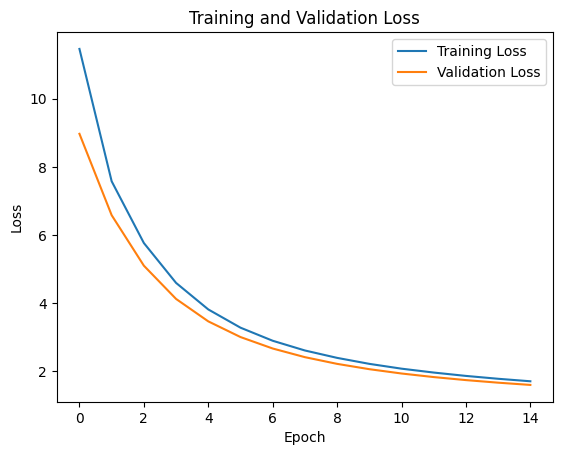

In [10]:
in_features = X_train.shape[1]
num_classes = y_train.unique().shape[0]
num_epochs = 15
learning_rate = 0.01

model = LogisticRegressionScratch(in_features=in_features, num_classes=num_classes)
optimizer = SGDScratch(model.parameters(), lr=learning_rate)
criterion = CrossEntropyScratch(num_classes=num_classes)
metrics = {'accuracy':AccuracyScratch()}
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion, custom_metrics=metrics)
trainer.fit(num_epochs=num_epochs)

## Concise Implementation of Logistic Regression

Epoch 1/10, Training Loss: 2.0381, Validation Loss: 1.8296
Epoch 2/10, Training Loss: 1.7844, Validation Loss: 1.7401
Epoch 3/10, Training Loss: 1.7316, Validation Loss: 1.7083
Epoch 4/10, Training Loss: 1.7080, Validation Loss: 1.6904
Epoch 5/10, Training Loss: 1.6852, Validation Loss: 1.6577
Epoch 6/10, Training Loss: 1.6565, Validation Loss: 1.6380
Epoch 7/10, Training Loss: 1.6404, Validation Loss: 1.6262
Epoch 8/10, Training Loss: 1.6303, Validation Loss: 1.6182
Epoch 9/10, Training Loss: 1.6230, Validation Loss: 1.6120
Epoch 10/10, Training Loss: 1.6173, Validation Loss: 1.6071


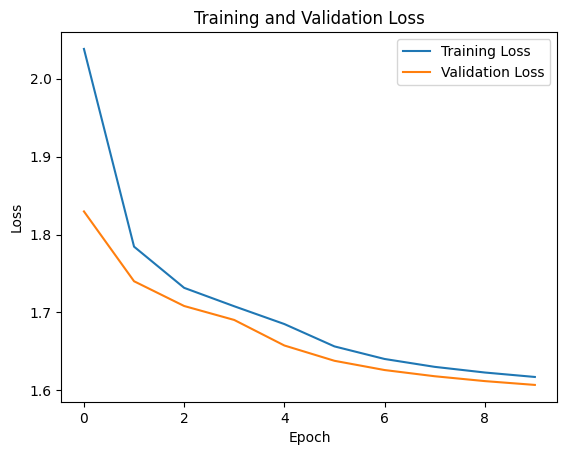

In [11]:
# Assuming X and y are your feature and target tensors
# Split Data into Train and Test Sets
train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

# Define DataLoader
batch_size = 256
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

# Define the Linear Regression Model
class LogisticRegression(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        out = self.linear(x)
        out = self.softmax(out)
        return out

model = LogisticRegression(input_size=X_train.shape[1], num_classes=y_train.unique().shape[0])

# Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.1)
trainer = TrainerScratch(model, train_dataloader, val_dataloader, optimizer, criterion)
trainer.fit(num_epochs=10)